# QC visualization helpers
Restructured into utilities and usage demos.

## Utility functions

In [1]:
# One-liner sparse commutation helper (Stim backend) that accepts sparse strings or Stim PauliStrings.
import importlib.util, pathlib
from stim_import import stim

def _to_sparse_spec(p):
    if isinstance(p, str):
        return p
    s = str(p)
    if s and s[0] in '+-':
        s = s[1:]
    tokens = []
    for idx, ch in enumerate(s):
        if ch in ('X', 'Y', 'Z'):
            tokens.append(f"{ch}{idx}")
    return ' '.join(tokens)

def commutes_sparse(pauli_a, paulis_b):
    """Return [a commutes with b_i] using sparse tokens like "Z0 Z2 X3".

    paulis_b can be an iterable of sparse strings or Stim PauliStrings (or a single one).
    Length is unified across inputs (max qubit index + 1)."""
    here = pathlib.Path('.').resolve()
    ph_path = here / 'pauli_handling.py'
    spec = importlib.util.spec_from_file_location('pauli_handling', ph_path)
    pauli_handling = importlib.util.module_from_spec(spec)
    assert spec and spec.loader
    spec.loader.exec_module(pauli_handling)
    parse_sparse_pauli = pauli_handling.parse_sparse_pauli

    if isinstance(paulis_b, (str, stim.PauliString)):
        paulis_list = [_to_sparse_spec(paulis_b)]
    else:
        paulis_list = [_to_sparse_spec(p) for p in paulis_b]

    specs = [_to_sparse_spec(pauli_a)] + paulis_list
    max_idx = -1
    for s in specs:
        for tok in s.replace('*', ' ').split():
            tok = tok.strip()
            if not tok:
                continue
            if tok[0].upper() in 'XYZ' and tok[1:].isdigit():
                max_idx = max(max_idx, int(tok[1:]))
    n = max_idx + 1 if max_idx >= 0 else 0
    a_ps = parse_sparse_pauli(specs[0], num_qubits=n)
    b_ps = [parse_sparse_pauli(t, num_qubits=n) for t in paulis_list]
    return [a_ps.commutes(b) for b in b_ps]


In [2]:
# Reorder CZ/H + Pauli rotations: move all Pauli evolutions to the end (sparse format).
import sys, pathlib, importlib.util
from stim_import import stim

# Bring backend helpers into scope
here = pathlib.Path('.').resolve()
for cand in [here] + list(here.parents):
    if (cand / 'connected-projects' / 'stabmbqc-game' / 'backend').exists():
        backend_root = cand / 'connected-projects' / 'stabmbqc-game' / 'backend'
        if str(backend_root) not in sys.path:
            sys.path.insert(0, str(backend_root))
        break

from clifford_handling import conjugate_pauli_via_map, build_cz_clifford_maps

ph_path = here / 'pauli_handling.py'
spec = importlib.util.spec_from_file_location('pauli_handling', ph_path)
pauli_handling = importlib.util.module_from_spec(spec)
assert spec and spec.loader
spec.loader.exec_module(pauli_handling)
parse_sparse_pauli = pauli_handling.parse_sparse_pauli
canonicalize_sparse_pauli = pauli_handling.canonicalize_sparse_pauli

def _conjugate_with_tableau(pauli_spec: str, tail_ops, n_qubits: int) -> str:
    """Conjugate sparse Pauli by a Clifford tail (ops are in forward order)."""
    tail_ops = list(tail_ops)
    if not tail_ops:
        return canonicalize_sparse_pauli(pauli_spec)
    circuit = stim.Circuit()
    for kind, data in tail_ops:
        if kind == 'CZ':
            circuit.append('CZ', list(data))
        elif kind == 'H':
            circuit.append('H', [data])
    tableau = circuit.to_tableau()
    p = parse_sparse_pauli(pauli_spec, num_qubits=n_qubits)
    result = stim.PauliString(n_qubits)
    for q in range(n_qubits):
        op = p[q]
        if op == 0:
            continue
        elif op == 1:  # X
            term = tableau.x_output(q)
        elif op == 3:  # Z
            term = tableau.z_output(q)
        elif op == 2:  # Y
            term = tableau.x_output(q) * tableau.z_output(q)
        else:
            raise ValueError(f"Unexpected Pauli opcode {op}")
        result *= term
    result *= p.sign
    s = str(result)
    if s and s[0] in '+-':
        s = s[1:]
    tokens = []
    for idx, ch in enumerate(s):
        if ch in ('X', 'Y', 'Z'):
            tokens.append(f"{ch}{idx}")
    return ' '.join(tokens)

def reorder_clifford_pauli(n_qubits, ops):
    """Given ops as [('CZ',(a,b)), ('H', q), ('X1', theta), ...], return (clifford_ops, paulis_sparse).

    Pauli evolutions are moved to the end; each is conjugated by the Clifford tail
    (CZ/H that originally followed it). Returns sparse strings for readability.
    """
    clifford_ops = []
    tail_ops = []  # future Clifford gates
    paulis_transformed = []
    for op in reversed(ops):
        if isinstance(op, tuple) and len(op) == 2 and op[0] == 'H':
            _, q = op
            tail_ops.append(('H', q))
            clifford_ops.append(('H', q))
        elif isinstance(op, tuple) and len(op) == 2 and op[0] == 'CZ':
            _, pair = op
            tail_ops.append(('CZ', pair))
            clifford_ops.append(('CZ', pair))
        elif isinstance(op, tuple) and len(op) == 2:
            pauli_spec, angle = op
            transformed = _conjugate_with_tableau(pauli_spec, reversed(tail_ops), n_qubits)
            paulis_transformed.append((canonicalize_sparse_pauli(transformed), angle))
        else:
            raise ValueError(f"Unknown op format {op}")
    paulis_transformed.reverse()
    clifford_ops.reverse()
    return clifford_ops, paulis_transformed


In [3]:
import os, sys, pathlib, importlib.util
import networkx as nx
import stim

# Keep dependencies light (avoid graphix/quimb load paths)
os.environ.setdefault('STABMBQC_BLOCK_GRAPHIX', '1')
os.environ.setdefault('NUMBA_DISABLE_JIT', '1')
os.environ.setdefault('STABMBQC_LIGHT_PES', '1')
for mod in list(sys.modules):
    if mod.startswith('graphix'):
        sys.modules.pop(mod, None)
for mod in ('extraction.dag', 'extraction.pauli_evolution', 'pdag_rep.pes.dag', 'pdag_rep.pes.pauli_evolution'):
    sys.modules.pop(mod, None)

def add_stabmbqc_extraction_to_path():
    here = pathlib.Path().resolve()
    search = []
    for cand in [here] + list(here.parents):
        search.append(cand / 'stabmbqc_extraction')
        search.append(cand / 'programing-based' / 'stabmbqc_extraction')
    for path in search:
        if path.exists() and path.is_dir():
            if str(path) not in sys.path:
                sys.path.insert(0, str(path))
            return path
    raise FileNotFoundError('Could not locate stabmbqc_extraction package in parents/siblings')

def ps_to_sparse(p: stim.PauliString) -> str:
    s = str(p)
    if s and s[0] in '+-':
        s = s[1:]
    tokens = []
    for idx, ch in enumerate(s):
        if ch in ('X', 'Y', 'Z'):
            tokens.append(f"{ch}{idx}")
    return ' '.join(tokens)

repo_path = add_stabmbqc_extraction_to_path()
print('Using stabmbqc_extraction from', repo_path)

from extraction.canonical_aliasing import canonical_alias
from extraction.pauli_evolution import PauliEvolution
from extraction.orchestrate import extract_reduce

# Load sparse Pauli parser from backend/pauli_handling.py (order-insensitive tokens)
ph_path = pathlib.Path('pauli_handling.py').resolve()
spec = importlib.util.spec_from_file_location('pauli_handling', ph_path)
pauli_handling = importlib.util.module_from_spec(spec)
assert spec and spec.loader
spec.loader.exec_module(pauli_handling)
parse_sparse_pauli = pauli_handling.parse_sparse_pauli

class MiniDAG:
    def __init__(self, num_qubits: int):
        self.num_qubits = num_qubits
        self._g = nx.DiGraph()
        self._counter = 0
    def add(self, evo: PauliEvolution):
        node_id = evo.id or f"n{self._counter}"
        self._counter += 1
        self._g.add_node(node_id, evo=evo)
        for existing in list(self._g.nodes()):
            if existing == node_id:
                continue
            existing_evo = self._g.nodes[existing]['evo']
            if not evo.commutes_with(existing_evo):
                self._g.add_edge(existing, node_id)
        return node_id
    def nodes(self):
        return list(self._g.nodes())
    def predecessors(self, u):
        return list(self._g.predecessors(u))
    def successors(self, u):
        return list(self._g.successors(u))
    def in_degree(self, u):
        return self._g.in_degree(u)
    def topological_order(self):
        return list(nx.topological_sort(self._g))
    def get_evolution(self, u):
        return self._g.nodes[u]['evo']
    def set_pauli(self, u, pauli):
        evo = self.get_evolution(u)
        self._g.nodes[u]['evo'] = PauliEvolution(pauli, evo.angle, evo.id, evo.meta)
    def remove_edge(self, u, v):
        if self._g.has_edge(u, v):
            self._g.remove_edge(u, v)
    @property
    def graph(self):
        return self._g


Using stabmbqc_extraction from /home/pafloxy/Documents/INRIAProjectVault/programing-based/stabmbqc_extraction


In [4]:
# Build a Qiskit circuit from (H, CZ, Pauli rotation) ops using the A/B register layout.
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate

def build_circuit_from_ops(ops, n_alice=3, n_bob=2):
    """Turn ops like ('H', q), ('CZ', (a,b)), ('X1', 'theta1') into a QuantumCircuit.

    Registers follow the notebook convention: Alice = qubits 0..n_alice-1, Bob = the rest.
    Pauli rotations use PauliEvolutionGate with shared Parameter objects per angle name.
    Bob qubits are initialized to |+>.
    """
    A = QuantumRegister(n_alice, "A")
    B = QuantumRegister(n_bob, "B")
    qc = QuantumCircuit(A, B)

    # Initialize Bob's qubits to |+>
    for qb in range(n_bob):
        qc.h(B[qb])
    qc.barrier()

    params = {}
    n_total = n_alice + n_bob

    def qref(idx):
        return A[idx] if idx < n_alice else B[idx - n_alice]

    def get_param(name: str) -> Parameter:
        if name not in params:
            params[name] = Parameter(name)
        return params[name]

    for op in ops:
        if isinstance(op, tuple) and len(op) == 2 and op[0] == 'H':
            _, q = op
            qc.h(qref(q))
        elif isinstance(op, tuple) and len(op) == 2 and op[0] == 'CZ':
            _, pair = op
            qc.cz(qref(pair[0]), qref(pair[1]))
        elif isinstance(op, tuple) and len(op) == 2:
            pauli_spec, angle_name = op
            # Build Pauli label string in little-endian order expected by Qiskit.
            label = ["I"] * n_total
            for tok in pauli_spec.replace("*", " ").split():
                tok = tok.strip()
                if not tok:
                    continue
                op_sym = tok[0].upper()
                idx = int(tok[1:])
                label[idx] = op_sym
            pauli_label = "".join(reversed(label))  # reverse for Qiskit ordering
            gate = PauliEvolutionGate(SparsePauliOp(pauli_label), time=get_param(angle_name))
            qc.append(gate, [qref(i) for i in range(n_total)])
        else:
            raise ValueError(f"Unknown op format {op}")

    return qc


## Usage examples

In [5]:
from qiskit import QuantumCircuit, QuantumRegister
# Example mapping: Alice = qubits 0,1,2; Bob = qubits 3,4
A = QuantumRegister(3, "A")
B = QuantumRegister(2, "B")
qc = QuantumCircuit(A, B)
qc.barrier()
qc.cz(A[1], B[0])
qc.cz(A[2], B[1])
qc.barrier()
from qiskit.circuit import Parameter
t1 = Parameter("θ1")
t2 = Parameter("θ2")
qc.rx(t1, A[1])
qc.rx(t2, B[0])
qc.barrier()
print(qc.draw(output='text'))


      ░        ░            ░ 
A_0: ─░────────░────────────░─
      ░        ░ ┌────────┐ ░ 
A_1: ─░──■─────░─┤ Rx(θ1) ├─░─
      ░  │     ░ └────────┘ ░ 
A_2: ─░──┼──■──░────────────░─
      ░  │  │  ░ ┌────────┐ ░ 
B_0: ─░──■──┼──░─┤ Rx(θ2) ├─░─
      ░     │  ░ └────────┘ ░ 
B_1: ─░─────■──░────────────░─
      ░        ░            ░ 


In [6]:
# Stim-based Clifford map demo for the CZ network above
import sys, pathlib
from stim_import import stim

repo_root = pathlib.Path('.').resolve()
if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))

from clifford_handling import build_cz_clifford_maps, conjugate_pauli_via_map

# Match the qiskit sketch: CZ(A[1], B[0]) and CZ(A[2], B[1]) -> edges (1,3) and (2,4)
cz_edges = [(0,1) , (0,4) , (1, 3), (2, 4)]
maps = build_cz_clifford_maps(cz_edges, num_qubits=5) 

p = stim.PauliString('XXX__')  # X on A0, Z on A2 (len=5 with identities)
fwd = conjugate_pauli_via_map(p, maps)
inv = conjugate_pauli_via_map(p, maps, inverse=True)
print(f'Input:       {p}')
print(f'Conjugated:  {fwd}')
print(f'Back via C†: {inv}')

# Dict form if you want to feed MBQC utilities
print('Dict form:', conjugate_pauli_via_map(p, maps, as_dict=False))

stablist = ['X3' , 'X4', 'X0 X1' , 'X1 X2', 'X0 X1 X2', 'Z0 Z1 Z2']
stablist_ = [conjugate_pauli_via_map(pa, maps, as_dict=False) for pa in stablist]
print('Pauli images:', list(zip(stablist, stablist_)))
print('Commutes with Z0 Z2 X3:', commutes_sparse('Z0 Z2 X3', stablist_))


Input:       +XXX__
Conjugated:  Y0 Y1 X2 Z3
Back via C†: Y0 Y1 X2 Z3
Dict form: Y0 Y1 X2 Z3
Pauli images: [('X3', 'Z1 X3'), ('X4', 'Z0 Z2 X4'), ('X0 X1', 'Y0 Y1 Z3 Z4'), ('X1 X2', 'Z0 X1 X2 Z3 Z4'), ('X0 X1 X2', 'Y0 Y1 X2 Z3'), ('Z0 Z1 Z2', 'Z0 Z1 Z2')]
Commutes with Z0 Z2 X3: [True, True, True, True, False, True]


In [7]:
import pauli_handling

canonicalize_sparse_pauli = pauli_handling.canonicalize_sparse_pauli
parse_sparse_pauli = pauli_handling.parse_sparse_pauli

spec_str = "X3 X1 X2"
canonical = canonicalize_sparse_pauli(spec_str)
pauli = parse_sparse_pauli(spec_str)
print("Input spec:", spec_str)
print("Canonical:", canonical)
print("Stim Pauli:", pauli)
print("As pretty string:", str(pauli))


Input spec: X3 X1 X2
Canonical: X1 X2 X3
Stim Pauli: +_XXX
As pretty string: +_XXX


In [8]:
# Example combining CZ, H, and Pauli rotations using reorder_clifford_pauli
n_qubits = 5
ops = [
    ('H', 0),
    ('CZ', (1, 3)),
    ('X1', 'theta1'),
    ('CZ', (0, 1)),
    ('H', 2),
    ('CZ', (0, 4)),
    ('Z0 X3 Z1', 'theta2'),
    ('H', 4),
    ('CZ', (2, 4)),
    ('X2 Z4', 'theta3'),
]

clifford_ops, pauli_rot_ops = reorder_clifford_pauli(n_qubits, ops)
print('Clifford prefix:', clifford_ops)
print('Pauli evolutions (sparse, after commuting):', pauli_rot_ops)
ops_reordered = clifford_ops + pauli_rot_ops


Clifford prefix: [('H', 0), ('CZ', (1, 3)), ('CZ', (0, 1)), ('H', 2), ('CZ', (0, 4)), ('H', 4), ('CZ', (2, 4))]
Pauli evolutions (sparse, after commuting): [('Z0 X1', 'theta1'), ('Z0 Z1 X3', 'theta2'), ('X2 Z4', 'theta3')]


In [9]:

qc = build_circuit_from_ops(ops_reordered)

qc.initialize
qc.draw('text', initial_state=True)


░ ┌───┐                ┌─────────────────────────┐»
A_0: |0>──────░─┤ H ├──■───■─────────┤0                        ├»
              ░ └───┘  │   │         │                         │»
A_1: |0>──────░───■────■───┼─────────┤1                        ├»
              ░   │  ┌───┐ │         │                         │»
A_2: |0>──────░───┼──┤ H ├─┼───────■─┤2 exp(-it IIIXZ)(theta1) ├»
        ┌───┐ ░   │  └───┘ │       │ │                         │»
B_0: |0>┤ H ├─░───■────────┼───────┼─┤3                        ├»
        ├───┤ ░            │ ┌───┐ │ │                         │»
B_1: |0>┤ H ├─░────────────■─┤ H ├─■─┤4                        ├»
        └───┘ ░              └───┘   └─────────────────────────┘»
«     ┌─────────────────────────┐┌─────────────────────────┐
«A_0: ┤0                        ├┤0                        ├
«     │                         ││                         │
«A_1: ┤1                        ├┤1                        ├
«     │                         ││                         │
«A_2: ┤2 exp(-it IXIZZ)(theta2) ├┤2 exp(-it ZIXII)(theta3) ├
«     │                         ││                         │
«B_0: ┤3                        ├┤3                        ├
«     │                         ││                         │
«B_1: ┤4                        ├┤4                        ├
«     └─────────────────────────┘└─────────────────────────┘

In [10]:
# StabMBQC extraction via orchestrate.py using the S/M example and two Pauli evolutions
import numpy as np

num_qubits = 5
S_specs = ['Y0 Y1 Z3 Z4', 'Z0 X1 X2 Z3 Z4', 'Z1 X3', 'Z0 Z2 X4']
M_specs = ['X1 Z3', 'Z3 X4']

S = [parse_sparse_pauli(s, num_qubits=num_qubits) for s in S_specs]
M = [parse_sparse_pauli(m, num_qubits=num_qubits) for m in M_specs]

# Canonical aliasing (use aliased S/M for extraction)
Sprime, Mprime, alias_S, alias_M = canonical_alias(S, M)
print('Sprime (sparse):', [ps_to_sparse(s) for s in Sprime])
print('Mprime (sparse):', [ps_to_sparse(m) for m in Mprime])
print('Alias maps:', {'S': alias_S, 'M': alias_M})

# Build DAG of Pauli evolutions (angles labeled theta1/theta2 for illustration)
theta1, theta2 = np.pi/7, np.pi/5
dag = MiniDAG(num_qubits=num_qubits)
n0 = dag.add(PauliEvolution(parse_sparse_pauli('Z0 X1', num_qubits=num_qubits), theta1, id='p0'))
n1 = dag.add(PauliEvolution(parse_sparse_pauli('X3', num_qubits=num_qubits), theta2, id='p1'))
print('Initial edges:', list(dag.graph.edges()))

extracted, dag2, log = extract_reduce(dag, Sprime, Mprime, alias_S, seed=0)
print('Extracted nodes:', extracted)
print('Edges after extraction:', list(dag2.graph.edges()))
print('Final axes (sparse):', {u: ps_to_sparse(dag2.get_evolution(u).pauli) for u in dag2.nodes()})
print('Rewrite certificates:', log)


Sprime (sparse): ['Y0 Y1 Z3 Z4', 'Z0 X1 X2 Z3 Z4', 'Z0 Y1 X2 Y3 Z4', 'Z0 Z2 X4']
Mprime (sparse): ['X1 Z3', 'X1 X4']
Alias maps: {'S': {0: array([1, 0, 0, 0], dtype=uint8), 1: array([0, 1, 0, 0], dtype=uint8), 2: array([0, 1, 1, 0], dtype=uint8), 3: array([0, 0, 0, 1], dtype=uint8)}, 'M': {0: array([1, 0], dtype=uint8), 1: array([1, 1], dtype=uint8)}}
Initial edges: []
Extracted nodes: ['p0']
Edges after extraction: []
Final axes (sparse): {'p0': 'Z0 X1', 'p1': 'X3'}
Rewrite certificates: {}


In [11]:
# Demo: Enhanced logical Pauli check (sparse format) - shows all 3 cases
import importlib.util, pathlib

# Load backend pauli_handling helpers
ph_path = pathlib.Path('pauli_handling.py').resolve()
spec = importlib.util.spec_from_file_location('pauli_handling', ph_path)
pauli_handling = importlib.util.module_from_spec(spec)
assert spec and spec.loader
spec.loader.exec_module(pauli_handling)

is_logical_pauli_sparse = pauli_handling.is_logical_pauli_sparse
parse_sparse_pauli = pauli_handling.parse_sparse_pauli

# 3-qubit repetition-code-like stabilizers: S = {Z0 Z1, Z1 Z2}
stabilizers = ["Z0 Z1", "Z1 Z2"]

print("=== Testing 3 Cases ===")
print("Stabilizers:", stabilizers)
print()

# Case 1: Logical operator (commutes with all, not in span)
candidates_logical = ["X0", "X2", "X0 X1 X2"]
print("1. LOGICAL operators (commute with all stabilizers, not generated by them):")
for cand in candidates_logical:
    status, details = is_logical_pauli_sparse(cand, stabilizers, num_qubits=3)
    print(f"   {cand}: {status}")
    if details: print(f"      details: {details}")

print()

# Case 2: In stabilizer span (generated by products of stabilizers)
candidates_stabilizer = ["Z0 Z1", "Z1 Z2", "Z0 Z2"]  # Z0 Z2 = (Z0 Z1) * (Z1 Z2)
print("2. STABILIZER operators (generated by products of stabilizers):")
for cand in candidates_stabilizer:
    status, details = is_logical_pauli_sparse(cand, stabilizers, num_qubits=3)
    print(f"   {cand}: {status}")
    if details: print(f"      details: {details}")

print()

# Case 3: Anticommuting (not logical, not in span)
candidates_anticommute = ["Y0", "Z0", "X1"]
print("3. ANTICOMMUTING operators (anticommute with some stabilizers):")
for cand in candidates_anticommute:
    status, details = is_logical_pauli_sparse(cand, stabilizers, num_qubits=3)
    print(f"   {cand}: {status}")
    if details: print(f"      details: {details}")


=== Testing 3 Cases ===
Stabilizers: ['Z0 Z1', 'Z1 Z2']

1. LOGICAL operators (commute with all stabilizers, not generated by them):
   X0: anticommuting
      details: {'anticommuting_with': [0], 'note': 'Anticommutes with generators [0]; not logical and not in stabilizer group.'}
   X2: anticommuting
      details: {'anticommuting_with': [1], 'note': 'Anticommutes with generators [1]; not logical and not in stabilizer group.'}
   X0 X1 X2: logical

2. STABILIZER operators (generated by products of stabilizers):
   Z0 Z1: stabilizer
      details: {'generator_indices': [0], 'product_sparse': 'Z0 Z1', 'note': 'Overall phase ignored in decomposition.'}
   Z1 Z2: stabilizer
      details: {'generator_indices': [1], 'product_sparse': 'Z1 Z2', 'note': 'Overall phase ignored in decomposition.'}
   Z0 Z2: stabilizer
      details: {'generator_indices': [0, 1], 'product_sparse': 'Z0 Z2', 'note': 'Overall phase ignored in decomposition.'}

3. ANTICOMMUTING operators (anticommute with some stab

# NEW

In [12]:
from clifford_from_map import *
from pauli_handling import *
from stabilizer_canonicalization import *
from qiskit_circuit_builder import *

import stim
import sys
from pathlib import Path

# ROOT = Path(__file__).resolve().parents[1]
# if str(ROOT) not in sys.path:
#     sys.path.insert(0, str(ROOT))


In [13]:
cz_edges = [(0,2) , (1,2) , (2, 3), (3, 4)]
maps = build_cz_clifford_maps(cz_edges, num_qubits=5) 

print('Dict form:', conjugate_pauli_via_map(p, maps, as_dict=False))

stablist = ['X0' , 'X1', 'X2' , 'X3', 'X4' , 'X4 Z3' , 'X1 X3 Z2']
stablist_ = [conjugate_pauli_via_map(pa, maps, as_dict=False) for pa in stablist]
print('Pauli images:', list(zip(stablist, stablist_)))


Dict form: Y0 Y1 X2 Z3
Pauli images: [('X0', 'X0 Z2'), ('X1', 'X1 Z2'), ('X2', 'Z0 Z1 X2 Z3'), ('X3', 'Z2 X3 Z4'), ('X4', 'Z3 X4'), ('X4 Z3', 'X4'), ('X1 X3 Z2', 'X1 Z2 X3 Z4')]


In [14]:
n_qubits = 5
ops = [
    ('X4', 'theta1'),
    ('CZ', (0, 2)),
    
    ('CZ', (2, 1)),
    
    ('CZ', (3, 4)),

    ('X3 X1', 'theta2'),
    
    ('CZ', (2, 3)),
    # ('X2 Z4', 'theta3'),
]

clifford_ops, pauli_rot_ops = reorder_clifford_pauli(n_qubits, ops)
print('Clifford prefix:', clifford_ops)
print('Pauli evolutions (sparse, after commuting):', pauli_rot_ops)
ops_reordered = clifford_ops + pauli_rot_ops


Clifford prefix: [('CZ', (0, 2)), ('CZ', (2, 1)), ('CZ', (3, 4)), ('CZ', (2, 3))]
Pauli evolutions (sparse, after commuting): [('Z3 X4', 'theta1'), ('X1 Z2 X3', 'theta2')]


In [16]:
c = build_circuit_from_ops(ops, n_alice=5, n_bob=0)


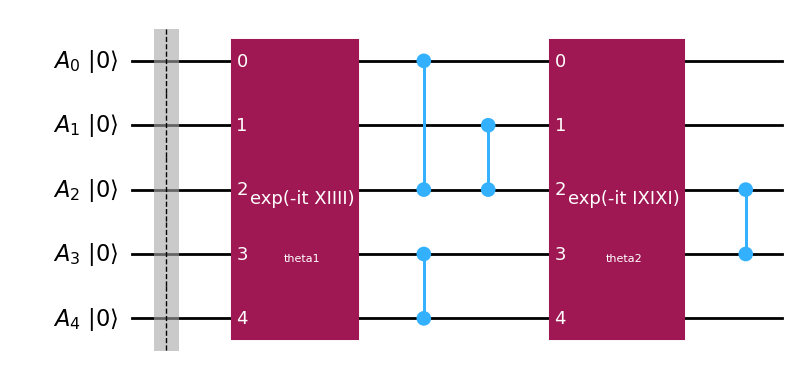

In [21]:
c.draw('mpl', initial_state=True, idle_wires=False)


In [ ]:
cz_edges = [(0,2) , (1,2) , (2, 3), (3, 4)]

for _ in range(1,len(cz_edges)) :
    ops = cz_edges[:_]
    print(f'\n=================\nUsing edges: {ops}')

    maps = build_cz_clifford_maps(ops, num_qubits=5) 

    # print('Dict form:', conjugate_pauli_via_map(p, maps, as_dict=False))

    stablist = ['X0' , 'X1', 'X2' , 'X3', 'X4' , 'X4 Z3' , 'X1 X3 Z2']
    stablist_ = [conjugate_pauli_via_map(pa, maps, as_dict=False) for pa in stablist]
    print('Pauli images:', list(zip(stablist, stablist_)))


In [ ]:
for _ in range(1,len(cz_edges)) :
    ops = cz_edges[:_]
    print(f'\n=================\nUsing edges: {ops}')
    maps = build_cz_clifford_maps(ops, num_qubits=5)
    tt = conjugate_pauli_via_map('X1 X3 Z2', maps, as_dict=False) 
    print('Result:', tt)
    # print('Pauli images:', list(zip(stablist, stablist_)))


In [ ]:
# stabcan = canonicalize_stabilizer_code(stablist_)


In [ ]:
list(zip(stabcan['stabilizers_sparse'], stabcan['destabilizers_sparse']))


In [ ]:

list(zip(stabcan['stabilizers_sparse'], stabcan['destabilizers_sparse'])) #, stabcan['logical_x_sparse'], stabcan['logical_z_sparse']
[commutes_sparse(a , stabcan['stabilizers_sparse']) for a in stabcan['destabilizers_sparse']]


In [ ]:

loglist__ = [stabcan['logical_x_sparse'][0], stabcan['logical_z_sparse'][0]]
[(commutes_sparse(p, stabcan['stabilizers_sparse']), commutes_sparse(p, stabcan['destabilizers_sparse'])) for p in loglist__]


In [ ]:
loglist__


In [ ]:
ds_pairs= list(zip(stabcan['stabilizers_sparse'], stabcan['destabilizers_sparse'])); ds_pairs


In [ ]:
clsd = synthesize_clifford_from_sd_pairs(ds_pairs, num_qubits=5)


In [ ]:
clsd['tableau'] 


In [ ]:
from stim_import import stim

pairs = [
    ("Z1 X3", "Z3"),
    ("Z0 Z2 X4", "X2"),
    ("Y0 Y1 Z3 Z4", "Z0"),
    ("Z0 X1 X2 Z3 Z4", "Z0 Z1"),
]
num_qubits = 5
res = synthesize_clifford_from_sd_pairs(pairs, num_qubits=num_qubits)
C = res["tableau"]
target_qubits = res["target_qubits"]

for i, q in enumerate(target_qubits):
    S = parse_sparse_pauli(pairs[i][0], num_qubits=num_qubits)
    D = parse_sparse_pauli(pairs[i][1], num_qubits=num_qubits)
    out_S = C(S)
    out_D = C(D)

    want_S = stim.PauliString(num_qubits)
    want_S[q] = "Z"
    want_D = stim.PauliString(num_qubits)
    want_D[q] = "X"

    assert out_S == want_S
    assert out_D == want_D


In [ ]:
# Evolve Pauli string via circuit in Stim
def evolve_pauli_via_circuit(pauli_string, circuit):
    """Evolve a Pauli string through a Stim circuit using tableau simulation.
    
    Args:
        pauli_string: Stim PauliString or sparse string like "X0 Z2"
        circuit: Stim Circuit object
        
    Returns:
        Evolved PauliString
    """
    if isinstance(pauli_string, str):
        # Convert sparse string to Stim PauliString
        pauli_string = parse_sparse_pauli(pauli_string, num_qubits=circuit.num_qubits)
    
    # Get the circuit's tableau representation
    tableau = circuit.to_tableau()
    
    # Evolve the Pauli string
    evolved = pauli_string
    for q in range(circuit.num_qubits):
        op = pauli_string[q]
        if op == 0:  # Identity
            continue
        elif op == 1:  # X
            evolved = tableau.x_output(q)
        elif op == 3:  # Z  
            evolved = tableau.z_output(q)
        elif op == 2:  # Y
            evolved = tableau.x_output(q) * tableau.z_output(q)
    
    evolved *= pauli_string.sign
    return evolved

# Test with multiple Pauli strings
test_paulis = stabcan['stabilizers_sparse']
print("\nEvolution results:")
for pauli in test_paulis:
    result = evolve_pauli_via_circuit(pauli, clsd['circuit'])
    print(f"{pauli} -> {ps_to_sparse(result)}")
